Pitroda, K. (2023) Skyratings: Unleashing 23K+ airline reviews!, Kaggle. Available at: https://www.kaggle.com/datasets/khushipitroda/airline-reviews/data (Accessed: 13 December 2023).

##Importing modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity


## Data preprocess

Here I read the file and exploring first 5 columns

In [2]:
df = pd.read_csv('Airline_Reviews.csv')
df.head()

,Unnamed: 0,Airline Name,Overall_Rating,Review_Title,Review Date,Verified,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money,Recommended
0,0,AB Aviation,9,"""pretty decent airline""",11th November 2019,True,Moroni to Moheli. Turned out to be a pretty ...,NaN,Solo Leisure,Economy Class,Moroni to Moheli,November 2019,4.0,5.0,4.0,4.0,NaN,NaN,3.0,yes
1,1,AB Aviation,1,"""Not a good airline""",25th June 2019,True,Moroni to Anjouan. It is a very small airline...,E120,Solo Leisure,Economy Class,Moroni to Anjouan,June 2019,2.0,2.0,1.0,1.0,NaN,NaN,2.0,no
2,2,AB Aviation,1,"""flight was fortunately short""",25th June 2019,True,Anjouan to Dzaoudzi. A very small airline an...,Embraer E120,Solo Leisure,Economy Class,Anjouan to Dzaoudzi,June 2019,2.0,1.0,1.0,1.0,NaN,NaN,2.0,no
3,3,Adria Airways,1,"""I will never fly again with Adria""",28th September 2019,False,Please do a favor yourself and do not fly wi...,NaN,Solo Leisure,Economy Class,Frankfurt to Pristina,September 2019,1.0,1.0,NaN,1.0,NaN,NaN,1.0,no
4,4,Adria Airways,1,"""it ruined our last days of holidays""",24th September 2019,True,Do not book a flight with this airline! My fr...,NaN,Couple Leisure,Economy Class,Sofia to Amsterdam via Ljubljana,September 2019,1.0,1.0,1.0,1.0,1.0,1.0,1.0,no


#Investigating part

In this part I will undersrand more information about my dataset:


1. Firstly I check type of all columns and drop unnamed column(as it is just number pf row)




In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23171 entries, 0 to 23170
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              23171 non-null  int64  
 1   Airline Name            23171 non-null  object 
 2   Overall_Rating          23171 non-null  object 
 3   Review_Title            23171 non-null  object 
 4   Review Date             23171 non-null  object 
 5   Verified                23171 non-null  bool   
 6   Review                  23171 non-null  object 
 7   Aircraft                7129 non-null   object 
 8   Type Of Traveller       19433 non-null  object 
 9   Seat Type               22075 non-null  object 
 10  Route                   19343 non-null  object 
 11  Date Flown              19417 non-null  object 
 12  Seat Comfort            19016 non-null  float64
 13  Cabin Staff Service     18911 non-null  float64
 14  Food & Beverages        14500 non-null

Finding sentiment inside review column to understand which number of positive and negative reviews I have(will check correlation in further steps). It is done before deleting unverified reviews, so that system could find a pattern

In [4]:
nltk.download('vader_lexicon')
text = df['Review']
analyzer = SentimentIntensityAnalyzer()
sentiments = text.apply(lambda x: analyzer.polarity_scores(x))
sentiments_df = pd.DataFrame(sentiments.tolist())
df_with_sentiments = pd.concat([df, sentiments_df], axis=1)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Here i drop all unverified reviews(as they may come from bots and do not display real situation) and columns which I don't need for my project, however they can significantly impact result of my method

In [5]:
columns_to_drop = ['Unnamed: 0', 'Review Date','Aircraft']
df = df.drop(columns=columns_to_drop)
df = df[df['Verified']]

Exploring null values inside dataframe


In [6]:
null_counts = df.isnull().sum()
print("null values:",null_counts)

null values: Airline Name                 0
Overall_Rating               0
Review_Title                 0
Verified                     0
Review                       0
Type Of Traveller            1
Seat Type                    0
Route                       11
Date Flown                   0
Seat Comfort              1230
Cabin Staff Service       1319
Food & Beverages          4148
Ground Service             710
Inflight Entertainment    6247
Wifi & Connectivity       8492
Value For Money              1
Recommended                  0
dtype: int64


In the next step i will handle missing data:
1.I use interpolate method(where ossible) to find values in between(as e.g. if customer didn't like Food he will not likke Wifi)
2.For all other mmissing values there was bot so much missing values so I just drop them

In [7]:
df.interpolate(inplace=True)
df.dropna(subset=['Inflight Entertainment'], inplace=True)
df.dropna(subset=['Type Of Traveller'], inplace=True)
df.dropna(subset=['Route'], inplace=True)

Here I will handle duplicate rows(just drop them)

In [8]:
df.drop_duplicates(inplace=True)
duplicate_rows = df.duplicated()
duplicate_rows_count = duplicate_rows.sum()
print("Duplicated rows:", duplicate_rows_count)

Duplicated rows: 0


I find out that overall rating column conissts of integer values, however it's class mentioned as object, so I change the type for simpler further investigation

In [9]:
df['Overall_Rating'] = df['Overall_Rating'].astype(int)

Splitting the dataset into valid and test to check the correctness of my method at the end

In [10]:
x = df.drop('Recommended', axis=1)
y = df['Recommended']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Deleting stop words (e.g. 'an','the' etc.)

In [11]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
def process_text(text):
    text = text.lower()
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words]
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in filtered_words]
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_words]
    processed_text = " ".join(lemmatized_words)
    return processed_text

df['Review'] = df['Review'].apply(process_text)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


##Exploratory data analysis.

In this part I will understand more about distribution of a data, will try to find hidden patterns and receive some valuable information about dataset

Cosine simillarity among all rows(+

In [12]:
numerical_columns = df.select_dtypes(include=['float64', 'int64'])
features = numerical_columns.values
cosine_sim_matrix = cosine_similarity(features, features)
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=range(1, len(df) + 1), columns=range(1, len(df) + 1))
print("Cosine Similarity Matrix:")
print(cosine_sim_df)


Cosine Similarity Matrix:
          1         2         3         4         5         6         7      \
1      1.000000  1.000000  0.959403  0.874716  0.802955  0.931149  0.948683   
2      1.000000  1.000000  0.959403  0.874716  0.802955  0.931149  0.948683   
3      0.959403  0.959403  1.000000  0.842213  0.733674  0.938466  0.943880   
4      0.874716  0.874716  0.842213  1.000000  0.750907  0.910828  0.910134   
5      0.802955  0.802955  0.733674  0.750907  1.000000  0.893321  0.761750   
...         ...       ...       ...       ...       ...       ...       ...   
12300  0.871857  0.871857  0.941795  0.747867  0.720064  0.905312  0.808736   
12301  0.876230  0.876230  0.942187  0.681530  0.677353  0.853525  0.825241   
12302  0.922777  0.922777  0.947003  0.790838  0.617158  0.840266  0.880369   
12303  0.917061  0.917061  0.889944  0.870873  0.594891  0.820905  0.860000   
12304  0.870388  0.870388  0.890724  0.609074  0.638978  0.776078  0.798199   

          8         9    

I could see that rows are highly correlated with each other. This result proves that dataset is collected correctly and mostly from simmilar custommers

array([[<Axes: title={'center': 'Overall_Rating'}>,
        <Axes: title={'center': 'Seat Comfort'}>,
        <Axes: title={'center': 'Cabin Staff Service'}>],
       [<Axes: title={'center': 'Food & Beverages'}>,
        <Axes: title={'center': 'Ground Service'}>,
        <Axes: title={'center': 'Inflight Entertainment'}>],
       [<Axes: title={'center': 'Wifi & Connectivity'}>,
        <Axes: title={'center': 'Value For Money'}>, <Axes: >]],
      dtype=object)

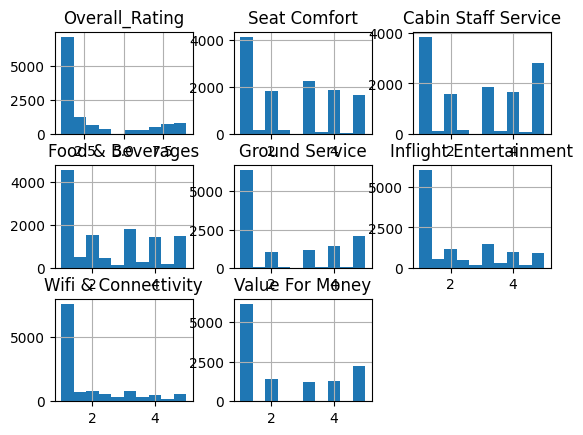

In [13]:
numerical_cols = df.select_dtypes(include = 'number').columns
df[numerical_cols].hist()

From this data I could understand that all integer and float columns are distributed normally(ratings from 1 to 5) and do not require adjustment(except for missing values)

<ipython-input-14-ab99043a1e66>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df2.iloc[:, :8].corr()


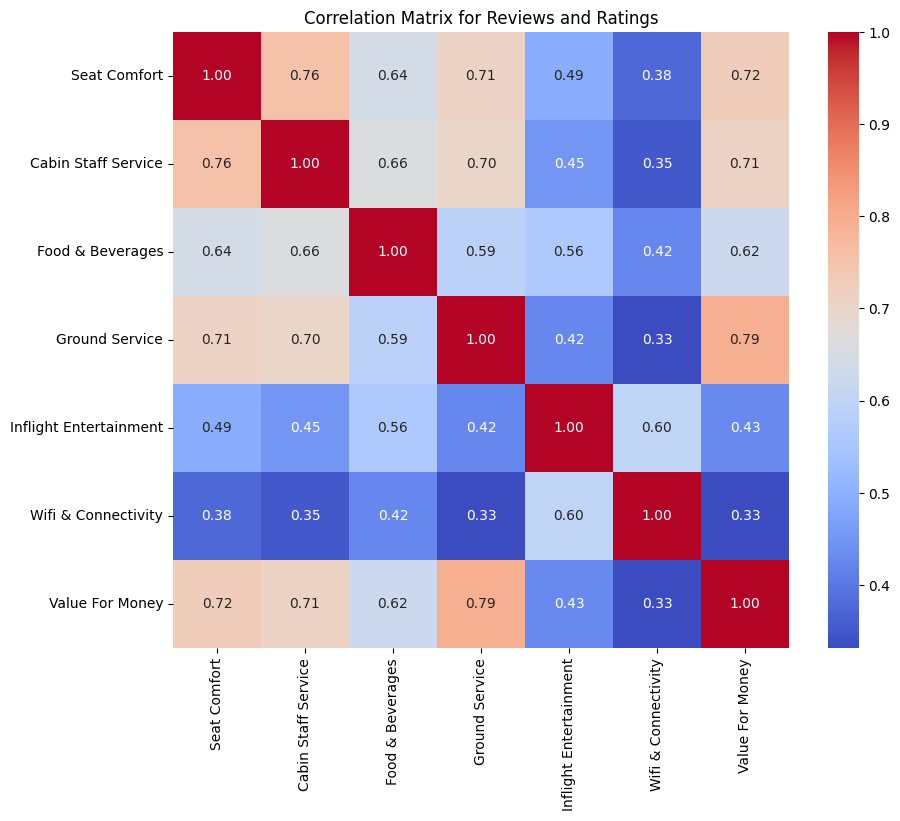

In [14]:
df2 = df[['Seat Comfort','Cabin Staff Service','Food & Beverages','Ground Service','Inflight Entertainment','Wifi & Connectivity','Value For Money','Recommended']]
correlation_matrix = df2.iloc[:, :8].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix for Reviews and Ratings')
plt.show()

From this correlation matrix I could see that all of the rating are highly correlated with each other(interpolation is good for such a data)

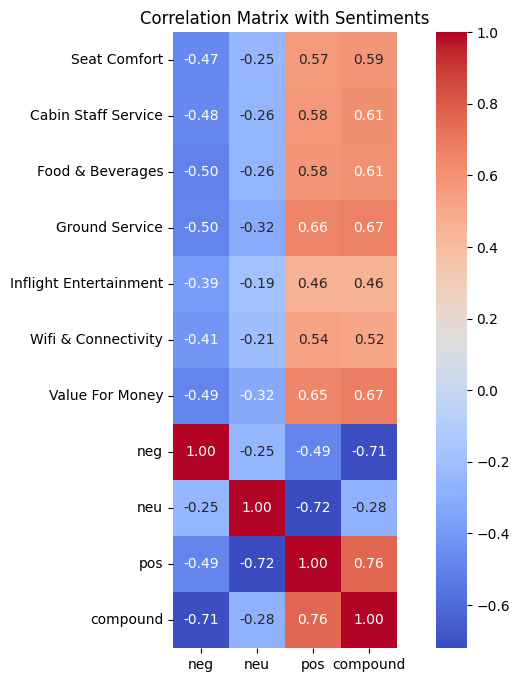

In [15]:
columns_for_matrix = ['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages',
                       'Ground Service', 'Inflight Entertainment',
                       'Wifi & Connectivity', 'Value For Money'] + list(sentiments_df.columns)
df3 = df_with_sentiments[columns_for_matrix]
correlation_matrix = df3.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix[['neg', 'neu', 'pos', 'compound']], annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix with Sentiments')
plt.show()



This correlation matrix displays the correlation with sntiments and displays which negative/positive review is highly impacted by

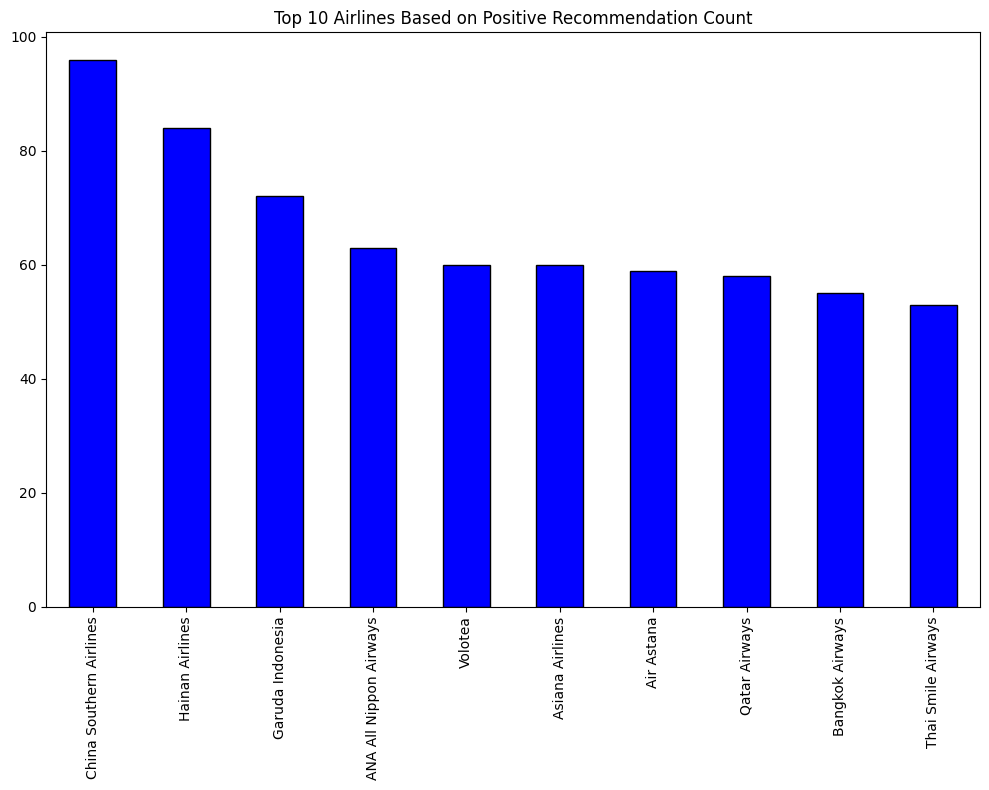

In [16]:
positive_recommendations = df[df['Recommended'] == 'yes']
airline_counts = positive_recommendations['Airline Name'].value_counts()
top_10_airlines = airline_counts.head(10)

plt.figure(figsize=(10, 8))
top_10_airlines.plot(kind='bar', color='blue', edgecolor='black')
plt.title('Top 10 Airlines Based on Positive Recommendation Count')


plt.tight_layout()

plt.show()

Displaying best 10 companies based on total number of positive reviews

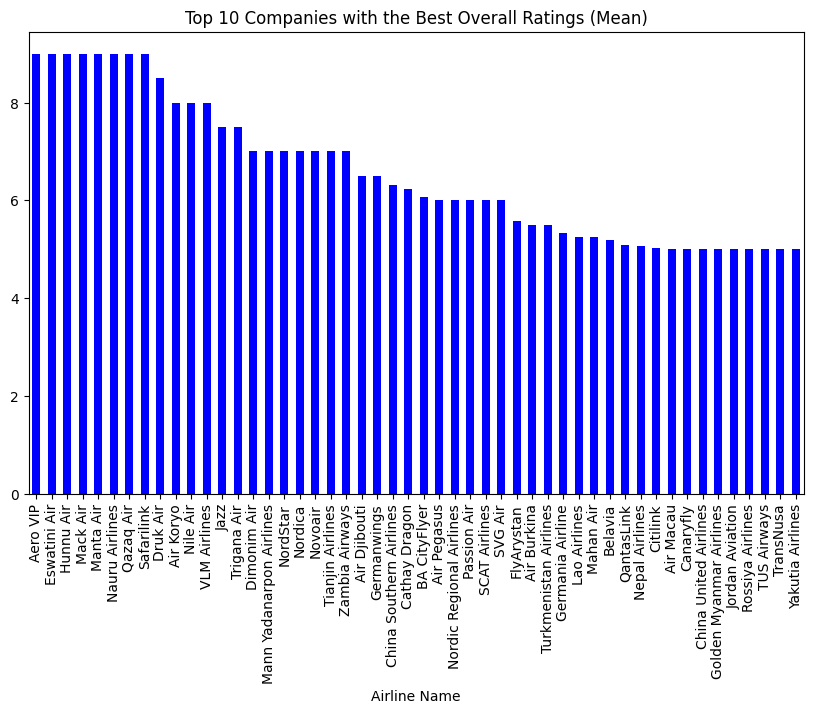

In [17]:
mean_ratings = df.groupby('Airline Name')['Overall_Rating'].mean()
top_50_companies = mean_ratings.nlargest(50)

# Plot the histogram
plt.figure(figsize=(10, 6))
top_50_companies.plot(kind='bar', color='blue')
plt.title('Top 10 Companies with the Best Overall Ratings (Mean)')

plt.show()

Top 50 companies based on onerall rating(mean is calculated for them, not sum)

##Problem solving

In this step i will transform columns for evaluating the method. For numerical columns I apply standard scaler, and onehotencoder for text columns

In [18]:
numerical_col = x_train.select_dtypes(include = 'number').columns
text_col = x_train.select_dtypes(include ='object').columns

ct = ColumnTransformer(
    transformers=[
        ('standard_scaler', StandardScaler(), numerical_col),
        ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'), text_col)
    ])
ct.fit(x_train)

x_train = ct.transform(x_train)
x_test = ct.transform(x_test)

I will use 2 methods: first is desicion tree and second is logistic regression, they both deal with classification problems. I will use gridsearsch to find best hyperparameters(will explain them below the code)

In [19]:
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_split': [1,2,3],
}
trcl = DecisionTreeClassifier()
trcl_grid_search = GridSearchCV(trcl, param_grid, cv=5, scoring='accuracy',n_jobs=-1)
trcl_grid_search.fit(x_train, y_train)
best_params = trcl_grid_search.best_params_
print("Best Parameters:", best_params)
best_model = trcl_grid_search.best_score_
print(best_model)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validat

Best Parameters: {'criterion': 'gini', 'min_samples_split': 3}
0.9613947590085348


1.criterion:function to measure the quality of a split
2.min_samples_split:minimum number of samples required to split an internal node

In [20]:
param_grid = {
    'C': [1,3,5,7],
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'max_iter': [100, 200, 300],
}

logr = LogisticRegression()
logr_grid_search = GridSearchCV(logr, param_grid, cv=5, scoring='accuracy',n_jobs=-1)
logr_grid_search.fit(x_train, y_train)
best_params = logr_grid_search.best_params_
print("Best Parameters:", best_params)
best_model = logr_grid_search.best_score_
print(best_model)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
120 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Sol

Best Parameters: {'C': 1, 'max_iter': 100, 'penalty': 'l2'}
0.9644425588491536


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


1.C:Inverse of regularization strength,smaller values specify stronger regularization
2.penalty: norm of the penalty for incorrect prediction
3.max iter: maximum number of iterations(this parameter is here because of the warning)

##Model evaluation

To evaluate the model I use inbuild function of sckit learn - classification report. It displays precision,f1,recall and accuracy; Based on macro average, weighted average and for each class separately

In [21]:
y_pred = logr_grid_search.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          no       0.97      0.97      0.97      1724
         yes       0.93      0.94      0.93       737

    accuracy                           0.96      2461
   macro avg       0.95      0.95      0.95      2461
weighted avg       0.96      0.96      0.96      2461

